# Mathematical model of a swarming behavior: Vicsek Model

Collective motion and swarming are among the most studied phenomena. Within the huge number of models that have been developed to catch such behavior from a microscopic description, the most famous is the model introduced by Tamás Vicsek et al. in 1995. It consists in point-like self-propelled particles that evolve at constant speed and align their velocity with their neighbours' one in presence of noise. Such a model shows collective motion at high density of particles or low noise on the alignment.

https://en.wikipedia.org/wiki/Vicsek_model

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from numba import jit

from matplotlib.animation import FuncAnimation  #creating animations and videos.
from IPython import display
from IPython.display import Video, HTML         #embedding videos in the notebook

%matplotlib inline

In [2]:
def plot_state(X,Y,theta,colors):   
    u=1
    U=u*np.cos(theta)
    V=u*np.sin(theta)
    
    #plt.figure(figsize=(10,10))
    plt.scatter(X,Y,30,c=colors,alpha=0.5)
    plt.quiver(X,Y,U,V,colors, scale=30)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    #plt.xticks([]),plt.yticks([])
    

def plot_state3D(X,Y,theta,colors):   
    
    ax=plt.axes(projection='3d');
    
    ax.scatter3D(X,Y,np.sin(theta), c=colors, marker="o",s=50,alpha=0.5);
    
    ax.set_xlim((-1,1))
    ax.set_ylim((-1,1))
    ax.set_zlim(-1,1) 
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('sin[Theta]')


In [3]:
#@jit(nopython=True)
def initialize_random(N=100, plot=True):
    X=np.random.uniform(-1,1,N)
    Y=np.random.uniform(-1,1,N)
    theta=2*np.pi*np.random.uniform(-1,1,N)
    theta=theta-np.mean(theta)
    colors=np.random.uniform(-1,1,N)
    
    u=1
    U=u*np.cos(theta)
    V=u*np.sin(theta)

    if plot: plot_state(X,Y,theta,colors)
        
    return X,Y,theta,colors

In [4]:
@jit(nopython=True)
def calc_trajectories(X,Y,theta, u=1,dt=0.01,th_noise=0.025,l=0.05, Nt=10):
    l2=l**2
    n=X.shape[0]
    x, y, th = np.zeros((n,Nt)), np.zeros((n,Nt)), np.zeros((n,Nt))

    for j in range(0,Nt):
        #Calculate velocities, the speed is the same.
        U=u*np.cos(theta)
        V=u*np.sin(theta)
        theta_new=theta.copy()
        #update coordinates
        X=X+U*dt;
        Y=Y+V*dt;

        #Simple double-periodicity (not entirely correct though!)
        X[X>1]=-1 +X[X>1]-1
        Y[Y>1]=-1 +Y[Y>1]-1
        X[X<-1]=1 +X[X<-1]+1
        Y[Y<-1]=1 +Y[Y<-1]+1

        #calculate average direction angle based on a radius of influence
        for i in range(1,n):
            L2=(X-X[i])**2+(Y-Y[i])**2
            theta_new[i]=np.mean(theta[L2<l2])

        theta_rand=th_noise*(2*np.random.uniform(0,1,n)-1)*2*np.pi # noise

        theta=theta_new + theta_rand # add the noise to the direction angle

        theta=theta % (2*np.pi) #keep the angles bounded to [0 2pi]

        x[:,j]=X; y[:,j]=Y; th[:,j]=theta;

    return x,y,th
    

In [5]:
%%time
x,y,th,colors=initialize_random(N=1000, plot=False)
x,y,th=calc_trajectories(x,y,th, u=1,dt=0.01,th_noise=0.02, l=0.05, Nt=800);

CPU times: user 9.39 s, sys: 3.81 s, total: 13.2 s
Wall time: 8.77 s


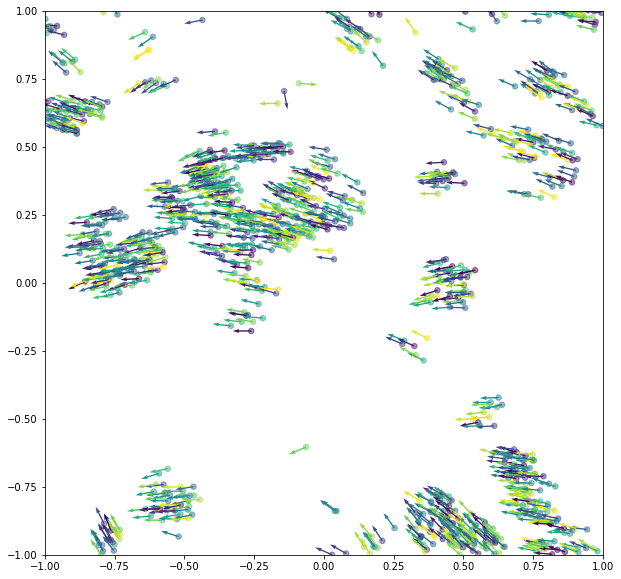

In [6]:
j=400;
fig = plt.figure(figsize=(10,10))
plot_state(x[:,j],y[:,j],th[:,j],colors);

In [7]:
n_skip=5 # plotting every n_skip time frame from the simulation to speed things up
N_frames=x.shape[1]//n_skip   # number of frames to plot for the video

def animation_func(j):
    fig.clear()
    #plot_state(x[:,n_skip*j],y[:,n_skip*j],th[:,n_skip*j],colors);
    plot_state(x[:,n_skip*j],y[:,n_skip*j],th[:,n_skip*j],colors)

fig = plt.figure(figsize=(10,10))
animation = FuncAnimation(fig, animation_func, 
                          frames = N_frames)

animation.save('swarming.mp4')
plt.close()
Video('swarming.mp4')

## Practice creating an xarray and saving it as netcfd

Follow an xarray data creation example here: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

- Save all model variables: x,y,th, colors. 

- Create their coordinates ID (for the fish id) and time (for timeframe of the model output).

- Include attributes for all variables and for the description of the dataset itself

- Save the xarray to a netcdf file called "swarm.nc" : we will load it from a separate notebook


In [8]:
import xarray as xr

In [9]:
swarm=xr.Dataset(data_vars=dict(
                        x = (["ID", "time"], x, {'attrs':'x location'}),
                        y = (["ID", "time"], y, {'attrs':'y location'}),
                        th= (["ID", "time"], th,{'attrs':'propagation direction'}),
                    colors= (["ID"], colors, {'attrs':'color ID'})
                      ),   
                  coords=dict( time=np.arange(x.shape[1]), ID=np.arange(x.shape[0])),
                  attrs={"description":"Simulation of a swarming behavior of fish using the Vicsek model with parameters l=0.05 and th_noise=0.02"} 
              )
swarm

<xarray.Dataset>
Dimensions:  (ID: 1000, time: 800)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
  * ID       (ID) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    x        (ID, time) float64 0.8087 0.8182 0.8276 ... 0.9838 0.9739 0.9639
    y        (ID, time) float64 -0.4204 -0.4234 -0.4268 ... -0.4758 -0.4761
    th       (ID, time) float64 5.981 5.938 5.976 6.085 ... 3.246 3.174 3.115
    colors   (ID) float64 0.6949 -0.6085 -0.3433 ... 0.08616 0.6183 0.9495
Attributes:
    description:  Simulation of a swarming behavior of fish using the Vicsek ...

In [10]:
swarm.to_netcdf('swarm.nc')